In [8]:
import os
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit.Chem import AllChem

from src.utils.constants import HOME_DIR, DATA_DIR

In [9]:
data_path = DATA_DIR + 'clean_data.csv'
data = pd.read_csv(data_path)

In [10]:
data

,Canonical_SMILES,LD50_mgkg
0,O=[N+]([O-])c1ccc(Cl)cc1,460.00
1,Nc1ccc([N+](=O)[O-])cc1,750.00
2,O=[N+]([O-])c1ccc(O)cc1,170.00
3,O=[N+]([O-])c1ccc(CCl)cc1,1809.00
4,COc1ccc([N+](=O)[O-])cc1,2300.00
...,...,...
5301,CCO[PH](=S)OCC,200.00
5302,CCCSP(C)SCCC,2.24
5303,C=CC(=O)OCC(C)O,250.00
5304,C[N+](C)(C)CCCl,600.00


In [13]:
sample_smile = data['Canonical_SMILES'][0]
print(sample_smile)
mol = AllChem.MolFromSmiles(sample_smile)
mol = AllChem.AddHs(mol)
AllChem.ComputeGasteigerCharges(mol)

O=[N+]([O-])c1ccc(Cl)cc1


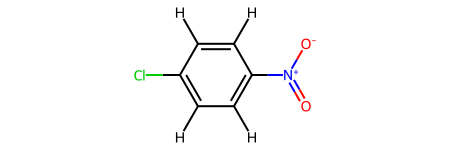

In [14]:
mol

In [ ]:
# print all the atoms and their charges and coordinates and atomic numbers

for atom in mol.GetAtoms():
    print('Atomic Number: ', atom.GetAtomicNum())


for atom in mol.GetAtoms():
    print('Atomic Number: ', atom.GetAtomicNum())

Atomic Number:  8
Atomic Number:  7
Atomic Number:  8
Atomic Number:  6
Atomic Number:  6
Atomic Number:  6
Atomic Number:  6
Atomic Number:  17
Atomic Number:  6
Atomic Number:  6
Atomic Number:  1
Atomic Number:  1
Atomic Number:  1
Atomic Number:  1


In [17]:
x = data['Canonical_SMILES']

y = data['LD50_mgkg'].to_list()

In [18]:
from rdkit import Chem
from torch_geometric.data import Data
import torch

def smiles_to_graph(smiles_list, labels):
    data_list = []
    for smiles, label in zip(smiles_list, labels):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue  # Skip invalid SMILES strings

        # Node features: Example - atomic number
        node_features = []
        for atom in mol.GetAtoms():
            node_features.append([atom.GetAtomicNum()])
        x = torch.tensor(node_features, dtype=torch.float)

        # Edge indices and edge attributes
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices.append((i, j))
            edge_indices.append((j, i))  # Undirected graph
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

        # Target value
        y = torch.tensor([label], dtype=torch.float)

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list


In [19]:
from torch_geometric.loader import DataLoader

# Convert to PyTorch Geometric Data objects
data_list = smiles_to_graph(x, y)

# Create DataLoader for batching
dataloader = DataLoader(data_list, batch_size=16, shuffle=True)

In [20]:
for data in dataloader:
    print(data)
    break

DataBatch(x=[260, 1], edge_index=[2, 540], y=[16], batch=[260], ptr=[17])


In [21]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 64)  # First GCN layer
        self.conv2 = GCNConv(64, 32)         # Second GCN layer
        self.fc = nn.Linear(32, 1)          # Fully connected layer for regression

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply GCN layers with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling (mean pooling over nodes)
        x = torch.mean(x, dim=0)

        # Fully connected layer for regression output
        out = self.fc(x)
        return out

In [22]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNRegressionModel(input_dim=1).to(device)  # Adjust input_dim based on node features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out = model(batch)
        
        loss = criterion(out.squeeze(), batch.y)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

/Users/junhalee/Desktop/CHEM 263/Final Project/drug_toxicology_prediction/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/junhalee/Desktop/CHEM 263/Final Project/drug_toxicology_prediction/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 6417311233.9375
Epoch 2, Loss: 6094214776.1250
Epoch 3, Loss: 6103928167.1250
Epoch 4, Loss: 6097513654.3750
Epoch 5, Loss: 6167501571.6250
Epoch 6, Loss: 6100465757.8750
Epoch 7, Loss: 6090953541.8750


KeyboardInterrupt: 

In [23]:
geometric_data = smiles_to_graph([sample_smile], [1])[0]

In [24]:
geometric_data

Data(x=[10, 1], edge_index=[2, 20], y=[1])

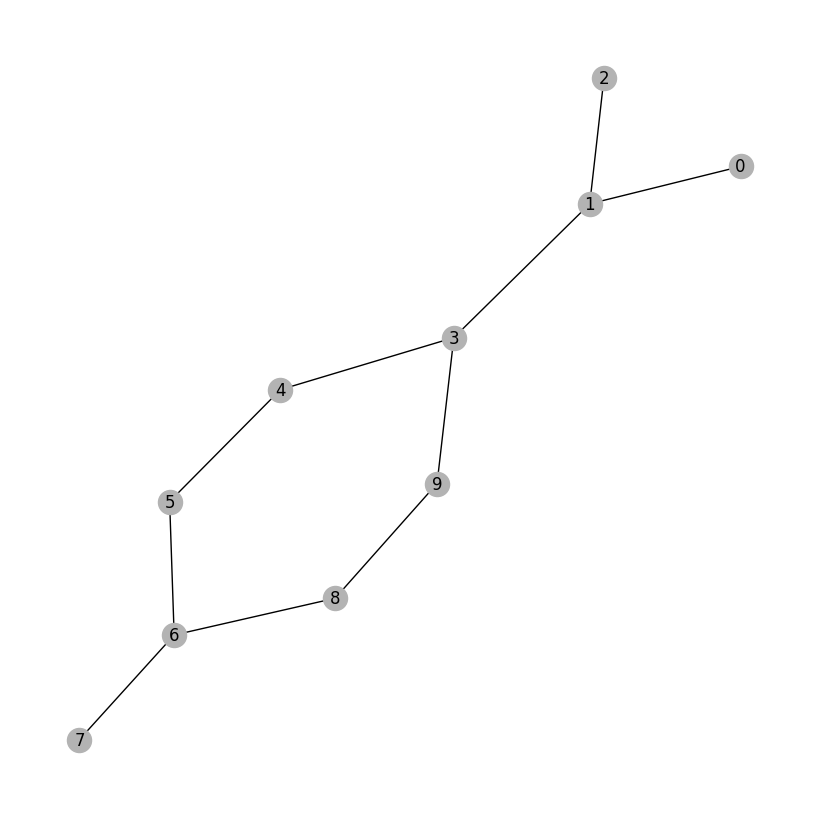

In [27]:
# visualize the graph of geometric_data
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edge_index = geometric_data.edge_index.cpu().numpy()
for i, j in edge_index.T:
    G.add_edge(i, j)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color=[[.7, .7, .7]])
# rotate the graph by 45 degrees


plt.show()
